In [1]:
import numpy as np
import cv2
from os import path as osp
from glob import glob
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from superpoint.settings import EXPER_PATH
from superpoint.evaluations.evaluation_tool import keep_true_keypoints, select_k_best, warp_keypoints, filter_keypoints  
from superpoint.evaluations.detector_evaluation import div0
import superpoint.evaluations.descriptor_evaluation as ev
from utils import plot_imgs

In [2]:
def keep_shared_points(data, keypoint_map, inv, keep_k_points=1000):
    """
    Compute a list of keypoints from the map, filter the list of points by keeping
    only the points that once mapped by H are still inside the shape of the map
    and keep at most 'keep_k_points' keypoints in the image.
    """
    

    keypoints = np.where(keypoint_map > 0)
    prob = keypoint_map[keypoints[0], keypoints[1]]
    
    #print(prob)
   
    keypoints = np.stack([keypoints[0], keypoints[1], prob], axis=-1)
    #print(keypoints)
    keypoints = keep_true_keypoints(data, keypoints, inv)
    #print(keypoints)
    #print("soretd:")
    idx = np.argsort(keypoints[:,2])[::-1]
    #print(idx)
    #print(keypoints[idx])
    keypoints = select_k_best(keypoints, keep_k_points)
    #print(keypoints)
    return keypoints.astype(int)

In [3]:
def get_ground_truth(data, keypoints, warped_keypoints, shape, correctness_thresh, inv):

    """
    Compute the ground truth keypoints matchings from image to image' where image' in the result 
    of warping image with H_matrix.
    """
    #keypoints = np.stack([keypoints[0], keypoints[1]], axis=-1)
    # Warp the original keypoints with the true homography
    true_warped_keypoints = warp_keypoints(data, keypoints[:, [1, 0]], inv)
    true_warped_keypoints = np.stack([true_warped_keypoints[:, 1],
                                          true_warped_keypoints[:, 0]], axis=-1)
    true_warped_keypoints = filter_keypoints(true_warped_keypoints, shape)
    print(warped_keypoints)
    print(true_warped_keypoints)
    #print(true_warped_keypoints.shape)
    #print(warped_keypoints.shape)
    diff = np.expand_dims(warped_keypoints, axis=1) - np.expand_dims(true_warped_keypoints, axis=0)
    dist = np.linalg.norm(diff, axis=-1)
    #print(dist)
    matches = np.less_equal(dist, correctness_thresh)
    return matches, len(true_warped_keypoints)

In [4]:
def compute_pr_rec(prob, gt, n_gt, total_n, remove_zero=1e-4, simplified=False):
    """
    computes precison and recall of the image
    return: precision and recall
    """ 
    matches = gt
    #print(gt.shape)
    tp = 0
    fp = 0
    tp_points = []
    matched = np.zeros(len(gt))
    for m in matches:
        correct = np.any(m)
        if correct:
            gt_idx = np.argmax(m)
            #tp +=1
            #at most one tp should be considerd for each ground turth point
            if gt_idx not in tp_points:
                tp_points.append(gt_idx)
                tp += 1
            else:
                fp += 1	

        else:
            #tp.append(False)
            fp += 1


    #compute precison and recall
    matching_score = tp / total_n if total_n!=0 else 0
    prec = tp / (tp+fp) if (tp+fp)!=0 else 0
    recall = tp / (n_gt) if n_gt!= 0 else 0
    #print(n_gt)
    #print(tp)
    #print(fp)

    return prec, recall, matching_score

In [5]:
def draw_matches(data):
    keypoints1 = [cv2.KeyPoint(p[1], p[0], 1) for p in data['keypoints1']]
    keypoints2 = [cv2.KeyPoint(p[1], p[0], 1) for p in data['keypoints2']]
    inliers = data['inliers'].astype(bool)
    matches = np.array(data['matches'])[inliers].tolist()
    img1 = np.concatenate([output['image1'], output['image1'], output['image1']], axis=2) * 255
    img2 = np.concatenate([output['image2'], output['image2'], output['image2']], axis=2) * 255
    return cv2.drawMatches( np.uint8(img1), keypoints1,  np.uint8(img2), keypoints2, matches,
                           None, matchColor=(0,255,0), singlePointColor=(0, 0, 255))

(692, 2)
(692, 2)
[[154 461]
 [365 771]
 [239 787]
 ...
 [208 476]
 [108 458]
 [171 556]]
[[156 460]
 [363 772]
 [239 782]
 ...
 [208 476]
 [108 458]
 [171 556]]
[[156 460]
 [363 772]
 [239 782]
 ...
 [208 476]
 [108 458]
 [171 556]]
[[154 461]
 [365 771]
 [239 787]
 ...
 [208 476]
 [108 458]
 [171 556]]
1000
[0.8526011560693642]
[0.8526011560693642]
0.0
0.59


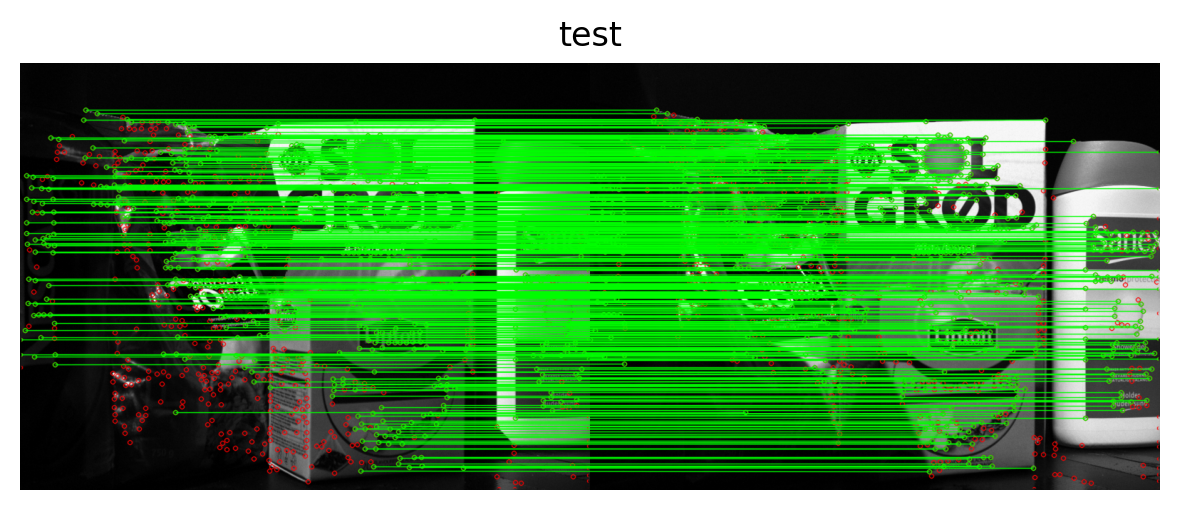

In [7]:
data = np.load("0_.npz")

#prob = np.load("prob.npy")
#warped_prob = np.load("warped_prob.npy")

prob = data['prob']
warped_prob = data['warped_prob']


shape = prob.shape
warped_shape = warped_prob.shape

 
# Keeps only the points shared between the two views
keypoints = keep_shared_points(data, prob, False, 1000)
warped_keypoints = keep_shared_points(data, warped_prob, True, 1000)



desc = data['desc'][keypoints[:, 0], keypoints[:, 1]]
warped_desc = data['warped_desc'][warped_keypoints[:, 0],
                                      warped_keypoints[:, 1]]

orb = False
# Match the keypoints with the warped_keypoints with nearest neighbor search
if orb:
    desc = desc.astype(np.uint8)
    warped_desc = warped_desc.astype(np.uint8)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
else:
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    
matches = bf.match(desc, warped_desc)
matches_idx = np.array([m.queryIdx for m in matches]).astype(int)
m_keypoints = keypoints[matches_idx, :]
matches_idx = np.array([m.trainIdx for m in matches]).astype(int)
m_warped_keypoints = warped_keypoints[matches_idx, :]
    
print(m_keypoints.shape)
print(m_warped_keypoints.shape)
    
precisions = []
recalls = []
ms = []

for t in range(3,4):
    #find ground truth
    true_keypoints, n_gt1 = get_ground_truth(data, m_warped_keypoints, m_keypoints, warped_shape, t, inv=True)
    true_warped_keypoints, n_gt2 = get_ground_truth(data, m_keypoints, m_warped_keypoints, shape, t, inv=False)

    #calculate precison and recall 
    print(len(warped_keypoints))
    prec1, recall1, ms1 = compute_pr_rec(m_warped_keypoints, true_warped_keypoints, n_gt2, len(warped_keypoints))
    prec2, recall2, ms2 =  compute_pr_rec(m_keypoints, true_keypoints, n_gt1, len(keypoints))

    #average precison and recall for two images
    prec = (prec1 + prec2)/2
    recall = (recall1 + recall2)/2
    matching_score = (ms1 + ms2)/2
   
    
    precisions.append(prec)
    recalls.append(recall)
    ms.append(matching_score)
    
sum_ = 0
for i in range(1,len(precisions)):
    sum_ += precisions[i]*np.abs((recalls[i]-recalls[i-1]))
    
mean_AP = np.sum(precisions[1:] * np.abs((np.array(recalls[1:]) - np.array(recalls[:-1]))))
print(precisions)
print(recalls)
#print(sum_)
print(mean_AP)
m = []
m = m + (ms)
m = m + (ms)

print(np.mean(m))


output = ev.compute_homography(data, 1000, 3, False)
output['image1'] = data['image']
output['image2'] = data['warped_image']
img = np.float32(draw_matches(output) / 255.)
plot_imgs([img], titles=["test"], dpi=200)